# Logistic Regression

Accuracy: 0.7638
F1 Score: 0.7780
AUC-ROC: 0.8280

Confusion Matrix:
             Predicted Down  Predicted Up
Actual Down            5279          2051
Actual Up              1514          6246


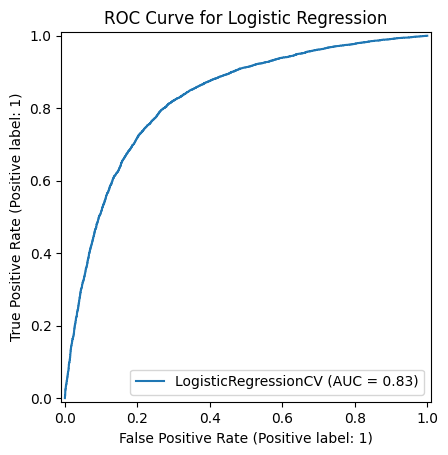

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, 
                            confusion_matrix, roc_auc_score,
                            RocCurveDisplay)
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("filtered_stocks_combined.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['ticker', 'Date'])

# Create target variable (1 if current close > previous close)
df['prev_close'] = df.groupby('ticker')['Close'].shift(1)
df['target'] = (df['Close'] > df['prev_close']).astype(int)
df = df.dropna(subset=['prev_close'])

# Feature engineering
features = ['Open', 'High', 'Low', 'Volume']
X = df[features]
y = df['target']

# Time-aware split preserving ticker groups
splitter = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=df['ticker']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training with built-in cross-validation
model = LogisticRegressionCV(
    Cs=10,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    max_iter=1000
)
model.fit(X_train_scaled, y_train)

# Predictions and probabilities
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, 
                  index=['Actual Down', 'Actual Up'],
                  columns=['Predicted Down', 'Predicted Up']))

# ROC Curve visualization
RocCurveDisplay.from_estimator(model, X_test_scaled, y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()